In [28]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

Things We should look at 
- how homogenous are today's festivals?
- what are the festivals that stand out as most unique? most median?
- what bands are the most "promiscuous" festival acts?
- are there other interesting patterns that indicate "behind the scenes" factors, such as shared booking/promoters, etc.?
- if you made a "consensus" festival for 2016, what would it look like? (would be great to design a fake poster for this)


In [2]:
df = pd.read_csv('/Users/hunterowens/Downloads/Festivals - 2016 (1).csv')

In [3]:
df.drop([0,1,2], inplace=True)
df.drop(['AVG RANK','# OF FESTS', 'PWR RANKING', 'Unnamed: 4',
        'ACL', 'EAUXCLAIRE','Unnamed: 26','BUMBERSHT']
        , axis=1, inplace=True)
df.set_index('ARTIST', inplace=True)

## Homogentity Score
- How similar to the avg festival is this festival 
- Computed Value is the Percentage of the Festival that appears in another fesitival 

In [4]:
def compute_percentage_of_lineup_in_other_festivals(lineup, df): 
    """Given a lineup from d[FESTIVAL_NAME], tell me what percentage is in another festival """
    sum_lineup = df[lineup].count()
    all_artists_from_other_fests = df.drop(lineup, axis=1).dropna(how='all').index.get_values()
    fest_lineup_list = df[lineup].dropna().index.get_values()
    common_artists_sum = len(set(all_artists_from_other_fests).intersection(fest_lineup_list))
    percentage = common_artists_sum / sum_lineup
    return percentage

In [5]:
d = {}
for column in df.columns.get_values():
    d[column] = 1 - compute_percentage_of_lineup_in_other_festivals(column, df)

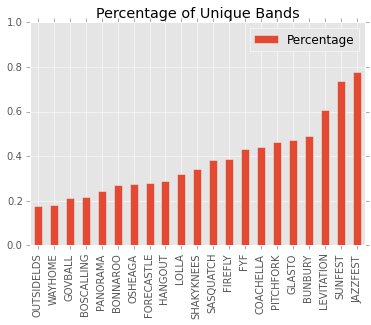

In [6]:
percentage_fest_df = pd.DataFrame.from_dict(d, orient='Index')
percentage_fest_df.columns = ['Percentage']
percentage_fest_df.sort_values(by='Percentage').plot(kind='Bar',
                                                     title="Percentage of Unique Bands",
                                                     ylim=(0,1))

## Percentage of Unique Bands in Percentiles of Lineup 

In [7]:
def compute_percentage_of_lineup_in_other_festivals_percentile(lineup, df, percentile=1): 
    """Given a lineup from d[FESTIVAL_NAME], tell me what percentage is in another festival. 
    Give a percentage of a lineup to cut by"""
    # get the sum
    sum_lineup = df[lineup].count()
    # get number in which to grab greater than
    sort_value = df[lineup].dropna().astype(int).sort_values().quantile(percentile)
    greater_than_true_series = df[lineup].dropna().astype(int) > sort_value
    fest_lineup_list = greater_than_true_series[greater_than_true_series == True].index.get_values()
    all_artists_from_other_fests = df.drop(lineup, axis=1).dropna(how='all').index.get_values()
    common_artists_sum = len(set(all_artists_from_other_fests).intersection(fest_lineup_list))
    percentage = common_artists_sum / sum_lineup
    return percentage

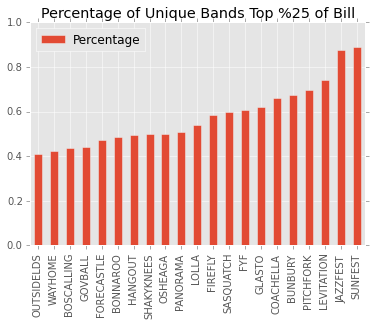

In [8]:
d = {}
for column in df.columns.get_values():
    d[column] = 1 - compute_percentage_of_lineup_in_other_festivals_percentile(column, df, .25)
percentage_fest_df = pd.DataFrame.from_dict(d, orient='Index')
percentage_fest_df.columns = ['Percentage']
percentage_fest_df.sort_values(by='Percentage').plot(kind='Bar',
                                                     title="Percentage of Unique Bands Top %25 of Bill",
                                                     ylim=(0,1))

## What about bands
- What are the top 10 most promiscious bands? 

In [9]:
df.count(axis=1).sort_values(ascending=False).head(25)

ARTIST
Vince Staples                            13
Nathaniel Rateliff & the Night Sweats    10
M83                                       9
Foals                                     9
Grimes                                    9
Kurt Vile & The Violators                 8
Oh Wonder                                 8
LCD Soundsystem                           8
Haim                                      8
Disclosure                                7
Big Grams                                 7
Marian Hill                               7
Major Lazer                               7
CHVRCHES                                  6
Miike Snow                                6
Silversun Pickups                         6
Sufjan Stevens                            6
Lany                                      6
Børns                                     6
Savages                                   6
The Last Shadow Puppets                   6
Unknown Mortal Orchestra                  6
Elle King                

In [10]:
df.columns

Index(['COACHELLA', 'GOVBALL', 'BONNAROO', 'JAZZFEST', 'SUNFEST', 'LEVITATION',
       'SHAKYKNEES', 'HANGOUT', 'BOSCALLING', 'SASQUATCH', 'BUNBURY',
       'FIREFLY', 'GLASTO', 'FORECASTLE', 'PITCHFORK', 'PANORAMA', 'WAYHOME',
       'LOLLA', 'OSHEAGA', 'OUTSIDELDS', 'FYF'],
      dtype='object')

## Power Rankings
* We calculate a power rank based on three factors. 
* Each act gets a score from 1-100 for a festival appearance, which is essentially percentile rank within fest. 
* Then, each festival is given a coefficient from 0-1 based on size. 

Then sum and multiply. 



In [39]:
fest_co = [i + 0.04761905 for i in np.arange(0,1, (1 / df.count().sort_values().count()))]

0.047619050000000003

In [43]:
festival_co = {}
for fest in enumerate(df.count().sort_values().iteritems()):
    fest_name = fest[1][0]
    pfest_co = fest_co[fest[0]]
    festival_co[fest_name] = pfest_co

{'BONNAROO': 0.85714285952380953,
 'BOSCALLING': 0.047619050000000003,
 'BUNBURY': 0.14285714523809523,
 'COACHELLA': 0.95238095476190465,
 'FIREFLY': 0.90476190714285709,
 'FORECASTLE': 0.095238097619047613,
 'FYF': 0.28571428809523808,
 'GLASTO': 0.66666666904761906,
 'GOVBALL': 0.42857143095238093,
 'HANGOUT': 0.57142857380952372,
 'JAZZFEST': 0.52380952619047616,
 'LEVITATION': 0.23809524047619046,
 'LOLLA': 1.0000000023809523,
 'OSHEAGA': 0.76190476428571419,
 'OUTSIDELDS': 0.61904762142857139,
 'PANORAMA': 0.38095238333333331,
 'PITCHFORK': 0.19047619285714285,
 'SASQUATCH': 0.80952381190476186,
 'SHAKYKNEES': 0.71428571666666663,
 'SUNFEST': 0.33333333571428569,
 'WAYHOME': 0.47619047857142854}

In [57]:
def calculate_power_rank(artist):
    """Calculates the power rankings"""
    artist_series = df.ix[artist]
    power_rank = 0
    for fest_tuple in artist_series.iteritems():        
        if not pd.isnull(fest_tuple[1]): 
            fest_count = df[fest_tuple[0]].count()
            artist_rank = fest_tuple[1]
            percentile = 1 - (float(artist_rank) / float(fest_count))
            power_rank += percentile * 100 * festival_co[fest_tuple[0]]
    return power_rank

In [58]:
power_ranks = {}
for artist in df.index:
    power_ranks[artist] = calculate_power_rank(artist)
power_rank_df = pd.DataFrame.from_dict(power_ranks, orient='index')
power_rank_df = power_rank_df.rename(columns={0: "Artist"})

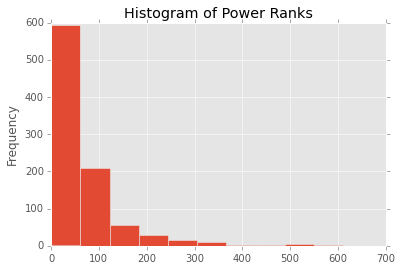

In [59]:
power_rank_df['Artist'].sort_values().plot(kind='hist', title="Histogram of Power Ranks")

In [61]:
# Top 10
power_rank_df['Artist'].sort_values()

Boom Forest                                0.000000
Flux Capacitor                             0.000000
Motel Radio                                0.000000
Noe                                        0.000000
Dr. Teeth and the Electric Mayhem          0.000000
Koa                                        0.000000
WD-Han                                     0.000000
Tangerine                                  0.000000
Davell Crawford                            0.000000
Bakery                                     0.000000
Leggy                                      0.000000
Honeysuckle                                0.000000
Michael Christmas                          0.000000
Palehound                                  0.207039
Los Colognes                               0.264550
Automagik                                  0.332226
The Greeting Committee                     0.584795
Lisa Hannigan and Aaron Dessner            0.621118
Trey Libra FKA Jacob Izrael                0.628931
Mad Anthony 

## Festivals WAR over Bands 
* This is each festivals WAR divided by the number of bands in the fest  - basically avg rank

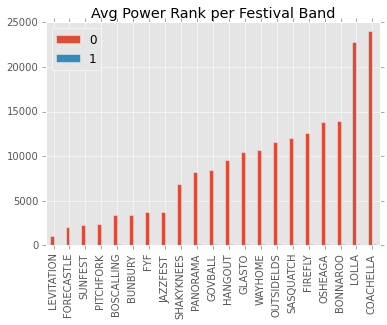

In [62]:
festival_rank = {} 
for festival in df.iteritems():
    fest = festival[0]
    sum_ranks = 0
    for artist in df[fest].dropna().iteritems():
        sum_ranks += power_rank_df.ix[artist[0]][0]
    festival_rank[fest] = (sum_ranks, sum_ranks / df[fest].count())
pd.DataFrame.from_dict(festival_rank, orient='index').sort_values(by=[0]
                                                                        ).plot(kind="bar", title="Avg Power Rank per Festival Band")

In [63]:
df.ix[['M83','LCD Soundsystem']].transpose().count()

ARTIST
M83                9
LCD Soundsystem    8
dtype: int64